In [1]:
import sys
sys.path.append("./source")

import pandas as pd
import NovakTyson
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import train_onestep
import predict_onestep
from sklearn.ensemble import RandomForestRegressor
from scipy.integrate import odeint
import train_lmmNet
import predict_lmmNet
import tensorflow as tf
import scicomp

In [3]:
# Number of time series to generate
N = 50

# cyclin synthesis and degradation are inhibited
time_points, novak_data = NovakTyson.simulate_custom(cyclin=0, MPF=0, tlast=1500, k1=0, v2_1=0, v2_2=0, cdc25_total=5)
data_numpy = np.zeros((N, novak_data.shape[1], novak_data.shape[2]))

cyclin_list = np.random.uniform(0, 32, N)
for i in range(N):
    # cyclin synthesis and degradation are inhibited
    _, data_numpy[i, :, :] = NovakTyson.simulate_custom(cyclin = cyclin_list[i], MPF=0, tlast=1500, k1=0, v2_1=0, v2_2=0, cdc25_total=5)
    
# replace all values that are numerically zero
data_numpy = np.where(data_numpy < 1e-4, 0, data_numpy)
print(data_numpy.shape)

(50, 7500, 7)


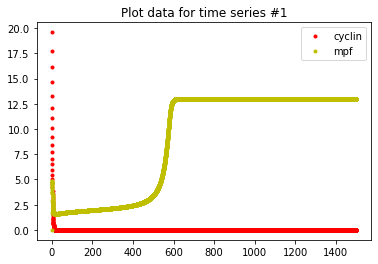

In [4]:
index = 1
plt.plot(time_points, data_numpy[index,:,0], 'r.', label='cyclin')
plt.plot(time_points, data_numpy[index,:,1], 'y.', label='mpf')

#plt.plot(time_points, predicted_test[:,0], 'b--', label='predicted dynamics')
#plt.plot(time_points, predicted_test[:,1], 'b--')
plt.legend()
plt.title("Plot data for time series #" + str(index))
plt.show()

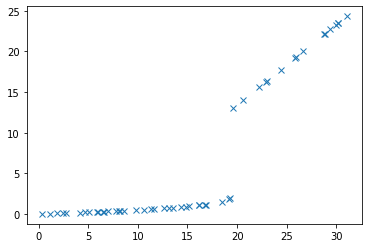

In [5]:
# plot the bifurcation diagram from data

mpf_list = [data_numpy[i][-1][1] for i in range(N)]
plt.plot(cyclin_list, mpf_list, 'x')

In [6]:
# select training and test
train_data = tf.convert_to_tensor(data_numpy[1:,:,:], dtype=tf.float32)
test_data = tf.convert_to_tensor(data_numpy[0,:,:], dtype=tf.float32)

model = train_lmmNet.train_easy(time_points, train_data)

In [10]:
# use these simulations to generate the bifurcation diagram
N = 20
simulated_data = np.zeros((N, test_data.shape[0], test_data.shape[1]))
init = test_data[0,:].numpy()
cyclin_test = np.random.uniform(0, 32, N)
for i in range(cyclin_test.shape[0]):
    init_copy = init
    init_copy[0] = cyclin_test[i]
    predicted_test = odeint(lambda x, t: predict_lmmNet.predict_fn(x, t, model), init_copy, time_points)
    simulated_data[i,:,:] = predicted_test


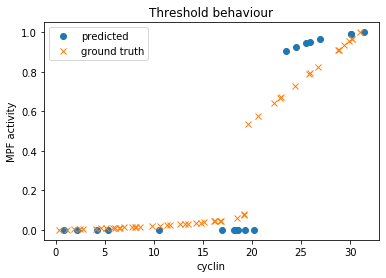

In [19]:
# plot the bifurcation diagram from data

mpf_test = [simulated_data[i][-1][1] for i in range(N)]
plt.plot(cyclin_test, scicomp.NormalizeData(mpf_test), 'o', label='predicted')
plt.plot(cyclin_list, scicomp.NormalizeData(mpf_list), 'x', label='ground truth')
plt.xlabel('cyclin')
plt.ylabel('MPF activity')
plt.legend()
plt.title('Threshold behaviour')
plt.show()

# High steady-state MPF activity

In [23]:
N = 50

# cyclin synthesis and degradation are inhibited
time_points, novak_data = NovakTyson.simulate_custom(step_size=3, tlast=1500)
data_numpy = np.zeros((N, novak_data.shape[1], novak_data.shape[2]))

cyclin_list = np.random.uniform(0, 10, N)
for i in range(N):
    # cyclin synthesis and degradation are inhibited
    _, data_numpy[i, :, :] = NovakTyson.simulate_custom(cyclin = cyclin_list[i], MPF=14, tlast=1500, k1=0, v2_1=0, v2_2=0, cdc25_total=5, step_size=3)
    
# replace all values that are numerically zero
data_numpy = np.where(data_numpy < 1e-4, 0, data_numpy)
print(data_numpy.shape)

(50, 500, 7)


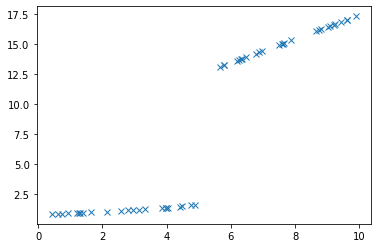

In [24]:
# plot the bifurcation diagram from data

mpf_high = [data_numpy[i][-1][1] for i in range(N)]
plt.plot(cyclin_list, mpf_high, 'x')

In [25]:
# select training and test
train_high = tf.convert_to_tensor(data_numpy[1:,:,:], dtype=tf.float32)
test_high = tf.convert_to_tensor(data_numpy[0,:,:], dtype=tf.float32)

model_high = train_lmmNet.train_easy(time_points, train_high)

In [57]:
# use these simulations to generate the bifurcation diagram
N = 20
simulated_high = np.zeros((N, test_high.shape[0], test_high.shape[1]))
init = test_high[0,:].numpy()
cyclin_high = np.random.uniform(0, 10, N)
for i in range(cyclin_high.shape[0]):
    init_copy = init
    init_copy[0] = cyclin_high[i]
    predicted_test = odeint(lambda x, t: predict_lmmNet.predict_fn(x, t, model_high), init_copy, time_points)
    simulated_high[i,:,:] = predicted_test

In [36]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

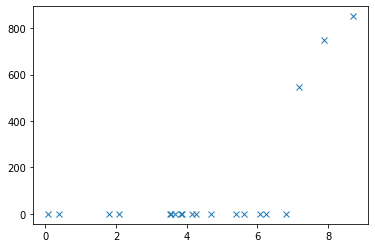

In [37]:
mpf_pred = [simulated_high[i][-1][1] for i in range(N)]
plt.plot(cyclin_high, np.maximum(mpf_pred, 0), 'x', label='data')

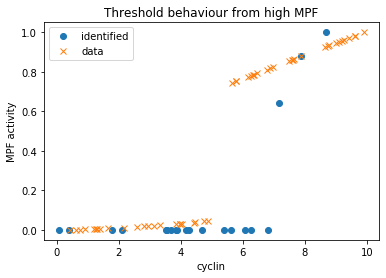

In [38]:
# plot the bifurcation diagram from data
mpf_norm = NormalizeData(np.maximum(mpf_pred, 0))
#mpf_high = [data_numpy[i][-1][1] for i in range(50)]
plt.plot(cyclin_high, mpf_norm, 'o', label='identified')
plt.plot(cyclin_list, NormalizeData(mpf_high), 'x', label='data')
plt.xlabel('cyclin')
plt.ylabel('MPF activity')
plt.legend()
plt.title('Threshold behaviour from high MPF')
plt.show()

# END

In [54]:
N = 100
h = 2.4

# cyclin synthesis and degradation are inhibited
time_points, novak_data = NovakTyson.simulate_custom(step_size=h, tlast=1500)
data_numpy = np.zeros((N, novak_data.shape[1], novak_data.shape[2]))

cyclin_list = np.random.uniform(0, 10, N)
for i in range(N):
    # cyclin synthesis and degradation are inhibited
    _, data_numpy[i, :, :] = NovakTyson.simulate_custom(cyclin = cyclin_list[i], MPF=14, tlast=1500, k1=0, v2_1=0, v2_2=0, cdc25_total=5, step_size=h)
    
# replace all values that are numerically zero
data_numpy = np.where(data_numpy < 1e-4, 0, data_numpy)
print(data_numpy.shape)

(100, 625, 7)


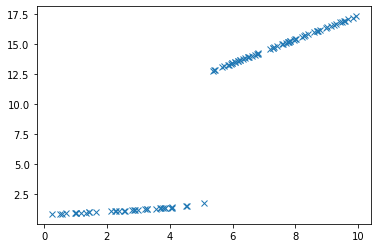

In [55]:
# plot the bifurcation diagram from data

mpf_high = [data_numpy[i][-1][1] for i in range(N)]
plt.plot(cyclin_list, mpf_high, 'x')

In [56]:
# select training and test
train_high = tf.convert_to_tensor(data_numpy[1:,:,:], dtype=tf.float32)
test_high = tf.convert_to_tensor(data_numpy[0,:,:], dtype=tf.float32)

model_high = train_lmmNet.train_easy(time_points, train_high)

In [43]:
# use these simulations to generate the bifurcation diagram
N = 50
simulated_high = np.zeros((N, test_high.shape[0], test_high.shape[1]))
init = test_high[0,:].numpy()
cyclin_high = np.random.uniform(0, 10, N)
for i in range(cyclin_high.shape[0]):
    init_copy = init
    init_copy[0] = cyclin_high[i]
    predicted_test = odeint(lambda x, t: predict_lmmNet.predict_fn(x, t, model_high), init_copy, time_points)
    simulated_high[i,:,:] = predicted_test

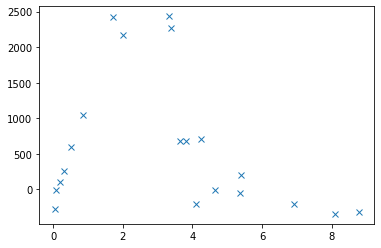

In [58]:
# next run this

mpf_pred = [simulated_high[i][-1][1] for i in range(N)]
#plt.plot(cyclin_high, np.maximum(mpf_pred, 0), 'x', label='data')
plt.plot(cyclin_high, mpf_pred, 'x', label='data')

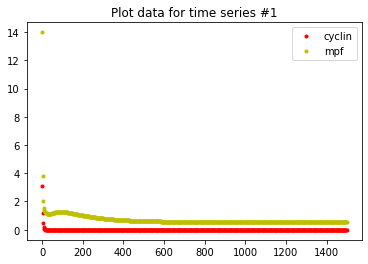

In [45]:
index = 1
plt.plot(time_points, simulated_high[index,:,0], 'r.', label='cyclin')
plt.plot(time_points, simulated_high[index,:,1], 'y.', label='mpf')

#plt.plot(time_points, predicted_test[:,0], 'b--', label='predicted dynamics')
#plt.plot(time_points, predicted_test[:,1], 'b--')
plt.legend()
plt.title("Plot data for time series #" + str(index))
plt.show()

In [48]:
# how about predictions on the training data?

simulated_train = np.zeros((train_high.shape[0], train_high.shape[1], train_high.shape[2]))

for i in range(train_high.shape[0]):
    init_copy = simulated_train[i,0,:]
    predicted_test = odeint(lambda x, t: predict_lmmNet.predict_fn(x, t, model_high), init_copy, time_points)
    simulated_train[i,:,:] = predicted_test

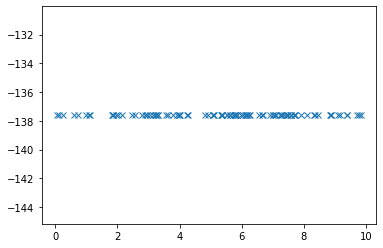

In [51]:
mpf_pred = [simulated_train[i][-1][1] for i in range(99)]
cyc = [train_high[index,0,0] for index in range(train_high.shape[0])]
#plt.plot(cyclin_high, np.maximum(mpf_pred, 0), 'x', label='data')
plt.plot(cyc, mpf_pred, 'x', label='data')

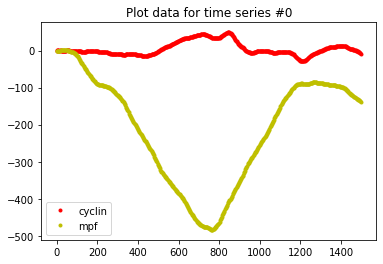

In [53]:
index = 0
plt.plot(time_points, simulated_train[index,:,0], 'r.', label='cyclin')
plt.plot(time_points, simulated_train[index,:,1], 'y.', label='mpf')

#plt.plot(time_points, predicted_test[:,0], 'b--', label='predicted dynamics')
#plt.plot(time_points, predicted_test[:,1], 'b--')
plt.legend()
plt.title("Plot data for time series #" + str(index))
plt.show()

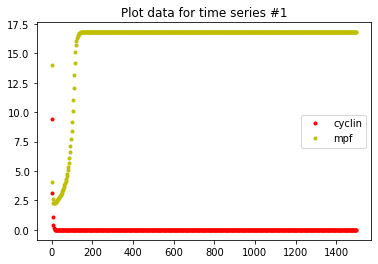

In [46]:
index = 1
plt.plot(time_points, data_numpy[index,:,0], 'r.', label='cyclin')
plt.plot(time_points, data_numpy[index,:,1], 'y.', label='mpf')

#plt.plot(time_points, predicted_test[:,0], 'b--', label='predicted dynamics')
#plt.plot(time_points, predicted_test[:,1], 'b--')
plt.legend()
plt.title("Plot data for time series #" + str(index))
plt.show()

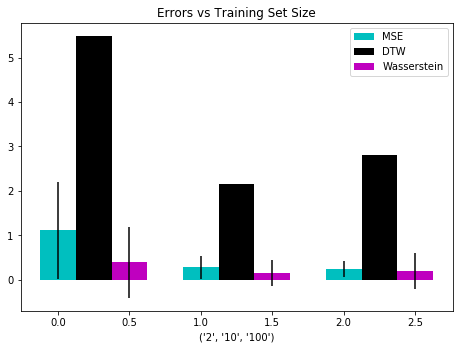

In [92]:
was = [np.mean(x) for x in error_dict['was'].values()]
mse = [np.mean(x) for x in error_dict['mse'].values()]
dtw = [np.mean(x) for x in error_dict['dtw'].values()]
X = np.arange(3)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, mse, color = 'c', width = 0.25, yerr=[np.std(x) for x in error_dict['mse'].values()])
ax.bar(X + 0.25, dtw, color = 'k', width = 0.25)
ax.bar(X + 0.50, was, color = 'm', width = 0.25,yerr=[np.std(x) for x in error_dict['was'].values()])

ax.set_xticks(X, ('2', '10', '100'))
ax.set_title('Errors vs Training Set Size')
ax.legend(labels=['MSE', 'DTW', 'Wasserstein'])

plt.show()